# Proyek Akhir: Menyelesaikan Permasalahan Institusi Pendidikan

- **Nama:** Permata Ayu Rahmawati
- **Email:** permathaayu21@gmail.com
- **ID Dicoding:** permatayra

## Persiapan

### Menyiapkan library yang dibutuhkan

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import joblib
from google.colab import files

### Menyiapkan data yang akan diguankan

In [4]:
# Load dataset
url = 'https://raw.githubusercontent.com/dicodingacademy/dicoding_dataset/main/students_performance/data.csv'
df = pd.read_csv(url, delimiter=';')

## Data Understanding


=== DATA SHAPE ===
Rows: 4424, Columns: 37

=== DATA TYPES ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Marital_status                                4424 non-null   int64  
 1   Application_mode                              4424 non-null   int64  
 2   Application_order                             4424 non-null   int64  
 3   Course                                        4424 non-null   int64  
 4   Daytime_evening_attendance                    4424 non-null   int64  
 5   Previous_qualification                        4424 non-null   int64  
 6   Previous_qualification_grade                  4424 non-null   float64
 7   Nacionality                                   4424 non-null   int64  
 8   Mothers_qualification                         4424 non-null   int64  
 9  

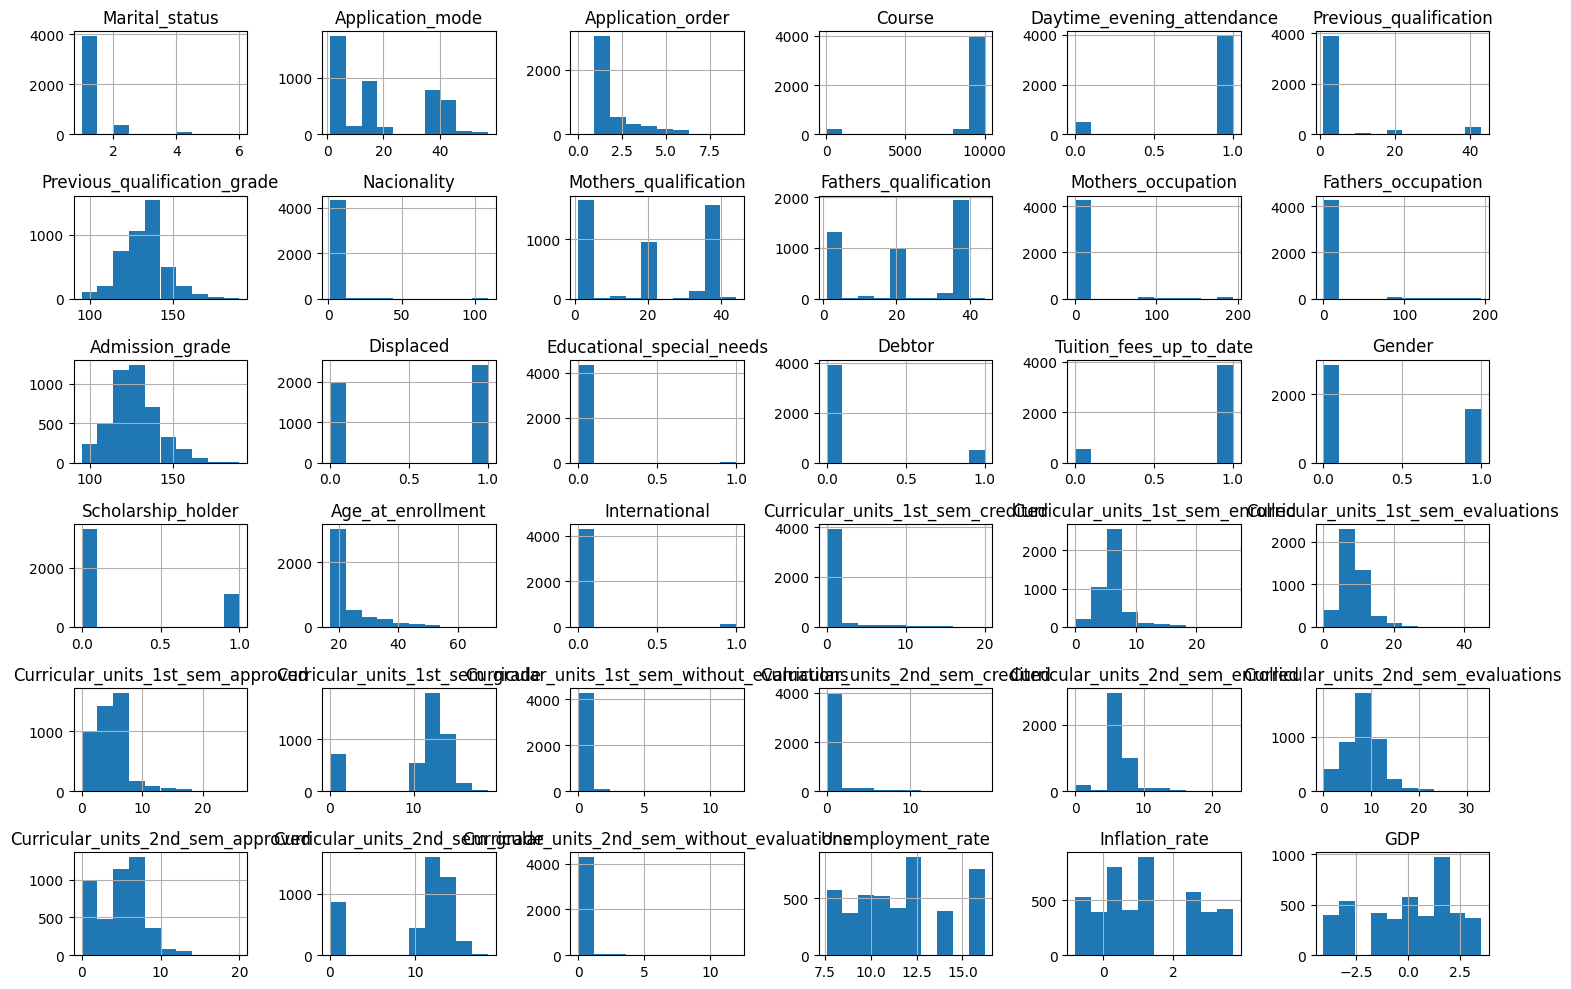

In [5]:
# Data Exploration
def explore_data(df):
    print("\n=== DATA SHAPE ===")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

    print("\n=== DATA TYPES ===")
    print(df.info())

    print("\n=== MISSING VALUES ===")
    print(df.isnull().sum())

    print("\n=== DESCRIPTIVE STATISTICS ===")
    print(df.describe())

    print("\n=== TARGET DISTRIBUTION ===")
    print(df['Status'].value_counts(normalize=True))

    # Visualize numeric features
    num_cols = df.select_dtypes(include=['int64','float64']).columns
    df[num_cols].hist(figsize=(15,10))
    plt.tight_layout()
    plt.show()

explore_data(df)

## Data Preparation / Preprocessing

In [6]:
# Feature Engineering
def create_features(df):
    # Academic performance features
    df['academic_performance'] = (df['Curricular_units_1st_sem_grade'] +
                                 df['Curricular_units_2nd_sem_grade']) / 2
    df['grade_difference'] = df['Curricular_units_2nd_sem_grade'] - df['Curricular_units_1st_sem_grade']

    # Attendance features
    df['attendance_rate'] = df['Daytime_evening_attendance'].map({1: 'Full', 0: 'Partial'})

    # Financial features
    df['financial_stability'] = df['Tuition_fees_up_to_date'].map({1: 'Yes', 0: 'No'})

    # Demographic features
    df['age_group'] = pd.cut(df['Age_at_enrollment'],
                            bins=[0, 20, 25, 30, 100],
                            labels=['<20', '20-25', '25-30', '30+'])

    # Target encoding
    df['target'] = df['Status'].apply(lambda x: 1 if x == 'Dropout' else 0)

    return df

df = create_features(df)

In [7]:
# Prepare features
features = ['Marital_status', 'Previous_qualification_grade',
            'academic_performance', 'grade_difference',
            'Debtor', 'Tuition_fees_up_to_date', 'Gender',
            'Scholarship_holder', 'Age_at_enrollment',
            'International', 'attendance_rate']

X = pd.get_dummies(df[features], drop_first=True)
y = df['target']

In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Model

In [9]:
# Create pipeline with SMOTE and Gradient Boosting
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5]
}

# Grid search
print("\nTraining model...")
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)


Training model...


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1],
                         'classifier__max_depth': [3, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='roc_auc')

In [10]:
# Best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

## Evaluation

In [11]:
# Evaluation
print("\n=== MODEL EVALUATION ===")
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))


=== MODEL EVALUATION ===
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       601
           1       0.75      0.75      0.75       284

    accuracy                           0.84       885
   macro avg       0.82      0.82      0.82       885
weighted avg       0.84      0.84      0.84       885


Confusion Matrix:
[[530  71]
 [ 70 214]]

ROC AUC Score: 0.894911063720091


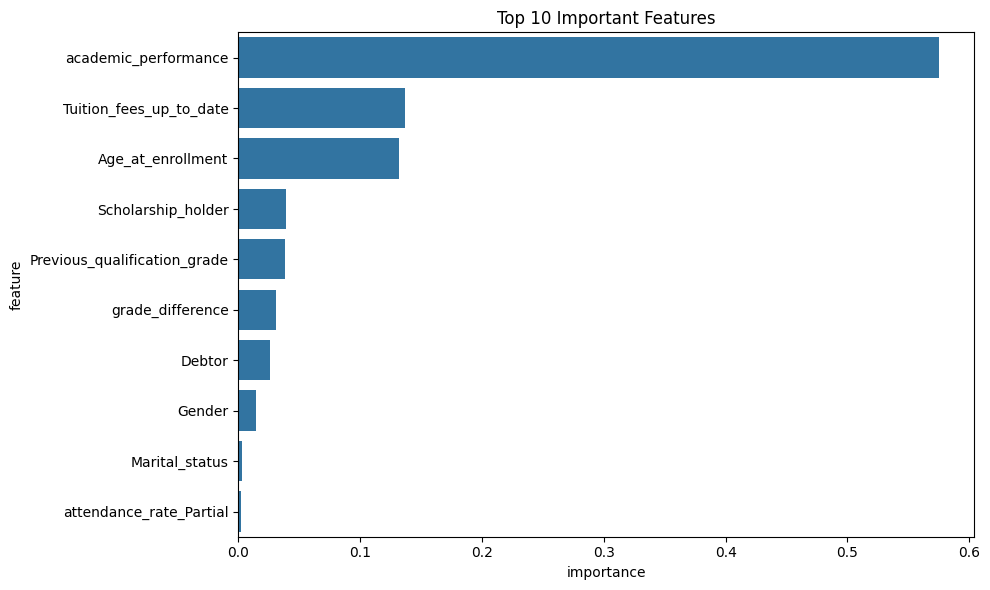

In [12]:
# Feature importance
importances = best_model.named_steps['classifier'].feature_importances_
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Important Features')
plt.tight_layout()
plt.show()

## Saved model

In [13]:
# Save additional exports
dashboard_data = df[features + ['Status']].copy()
dashboard_data.to_csv('student_performance_for_looker.csv', index=False)

In [14]:
files.download('student_performance_for_looker.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
# For Streamlit compatibility
joblib.dump(best_model, 'dropout_model.pkl')
joblib.dump(X.columns, 'feature_columns.pkl')
print("\nAdditional files saved for Streamlit deployment")


Additional files saved for Streamlit deployment


In [16]:
files.download('dropout_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
files.download('feature_columns.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>